In [0]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

     |████████████████████████████████| 25.0MB 1.5MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 74.8MB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [0]:
!pip install kmc2

     |████████████████████████████████| 102kB 2.4MB/s 
     |████████████████████████████████| 163kB 8.9MB/s 
  Created wheel for kmc2: filename=kmc2-0.1-cp36-cp36m-linux_x86_64.whl size=252216 sha256=c841374be20bf74ea35753a2b06bf4b1bd4088bdbfea1789934fd601601839e3
  Stored in directory: /root/.cache/pip/wheels/5c/ba/f0/4c8b421be72d4f2d1a93233c2f6f591e7d8b0bda05a1f4616f
Successfully built kmc2


In [0]:
# 캐글 API 버전 갱신을 위한 작업... 반드시 버전이 1.5.6 이어야 함

!ls -lha kaggle.json

!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6

-rw-r--r-- 1 root root 62 Dec  5 12:30 kaggle.json
Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (19.3.1)
     |████████████████████████████████| 61kB 2.0MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=7d3b861bcc0cd7bb12663d621cc41e550a6e3fcd8a391cbd3364b4dc8a8612ca
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle


In [0]:

# 캐글연동을 위한 토큰 입력
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


# 버전이 1.5.6 이 아니면, 진행할 수 없다
! kaggle -v


Kaggle API 1.5.6


In [0]:

! kaggle competitions download -c 2019-ml-finalproject
! unzip 2019-ml-finalproject.zip

100% 65.0M/65.0M [00:01<00:00, 22.4MB/s]
100% 65.0M/65.0M [00:01<00:00, 37.4MB/s]
Archive:  2019-ml-finalproject.zip
  inflating: Label2Names.csv         
  inflating: sample_submission.csv   
  inflating: testAll_v2/image_0001.jpg  
  inflating: testAll_v2/image_0002.jpg  
  inflating: testAll_v2/image_0003.jpg  
  inflating: testAll_v2/image_0004.jpg  
  inflating: testAll_v2/image_0005.jpg  
  inflating: testAll_v2/image_0006.jpg  
  inflating: testAll_v2/image_0007.jpg  
  inflating: testAll_v2/image_0008.jpg  
  inflating: testAll_v2/image_0009.jpg  
  inflating: testAll_v2/image_0010.jpg  
  inflating: testAll_v2/image_0011.jpg  
  inflating: testAll_v2/image_0012.jpg  
  inflating: testAll_v2/image_0013.jpg  
  inflating: testAll_v2/image_0014.jpg  
  inflating: testAll_v2/image_0015.jpg  
  inflating: testAll_v2/image_0016.jpg  
  inflating: testAll_v2/image_0017.jpg  
  inflating: testAll_v2/image_0018.jpg  
  inflating: testAll_v2/image_0019.jpg  
  inflating: testAll_v2/imag

In [0]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from scipy.cluster.vq import vq
import pandas as pd
import numpy as np
import cv2 
import os
import pickle
import math

import kmc2
import cupy as xp
from svm import SVM
from tqdm import tqdm

from PIL import Image

import matplotlib.pyplot as plt
#from sklearn.svm import SVC



In [0]:
df_data=pd.read_csv('/content/Label2Names.csv',header=None)
class_name=df_data[1].tolist()
df_data

class_name.append('BACKGROUND_Google')

In [0]:
def resize(dir,step):
  img= cv2.imread(dir)
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img_gray=cv2.resize(img_gray, (step,step))
  return img_gray 
  

In [0]:
def weak_sift(gray):
  sift=cv2.xfeatures2d_SIFT.create()
  kp,des=sift.detectAndCompute(gray,None)

  return des
  
def dense_sift(gray,step):
  sift=cv2.xfeatures2d_SIFT.create()
  keypoints=[]
  w,h=gray.shape
  keypoints=[cv2.KeyPoint(i,j,step) for i in range(0,h,step) for j in range(0,w,step)]
  kp,des=sift.compute(gray,keypoints)
  
  return des

In [0]:
IMGSIZE=256
STEP=8

In [0]:
train_root_path="./train"
len(os.listdir(train_root_path))
train_data=[]
label=[]
train_des=[]
cn=1
for lis in tqdm(class_name):
#for lis in tqdm(class_name[:15]):
  img_list=os.listdir(train_root_path+'/'+lis)
  for i in img_list:
    gray=resize(train_root_path+'/'+lis+'/'+i,IMGSIZE)
    train_des.append(dense_sift(gray,STEP))
    #train_data.append(gray)
    label.append(cn)
  cn+=1
train_data=np.array(train_data)

100%|██████████| 102/102 [02:50<00:00,  1.69s/it]


In [0]:
test_root_path="./testAll_v2"
len(os.listdir(train_root_path))
test_data=[]
test_des=[]
test_name=[]
lis=os.listdir(test_root_path)
lis.sort()
for lis in tqdm(lis):
    gray=resize(test_root_path+'/'+lis,IMGSIZE)
    #test_data.append(gray)
    test_des.append(dense_sift(gray,STEP))
    test_name.append(lis)

test_data=np.array(test_data)


100%|██████████| 1692/1692 [01:35<00:00, 17.64it/s]


In [0]:
'''
with open('train_des.txt','wb') as f:
  pickle.dump(train_des,f)
with open('test_des.txt','wb') as f:
  pickle.dump(test_des,f)

with open('train_data.txt','wb') as f:
  pickle.dump(train_data,f)
with open('test_data.txt','wb') as f:
  pickle.dump(test_data,f)
'''

"\nwith open('train_des.txt','wb') as f:\n  pickle.dump(train_des,f)\nwith open('test_des.txt','wb') as f:\n  pickle.dump(test_des,f)\n\nwith open('train_data.txt','wb') as f:\n  pickle.dump(train_data,f)\nwith open('test_data.txt','wb') as f:\n  pickle.dump(test_data,f)\n"

In [0]:
'''
with open('train_des.txt','rb') as f:
  train_des=pickle.load(train_des,f)
with open('test_des.txt','rb') as f:
  test_des=pickle.load(test_des,f)

with open('train_data.txt','rb') as f:
  train_data=pickle.load(train_data,f)
with open('test_data.txt','rb') as f:
  test_data=pickle.load(test_data,f)
with open('histogram400_256_8.txt','rb') as f:
  h_list=pickle.load(f)
with open('histogram_test400_256_8.txt','rb') as f:
  test_h=pickle.load(f)
with open('label.txt','rb') as f:
  label=pickle.load(f)
with open('test_name.txt','rb') as f:
  test_name=pickle.load(f)
'''

"\nwith open('train_des.txt','rb') as f:\n  train_des=pickle.load(train_des,f)\nwith open('test_des.txt','rb') as f:\n  test_des=pickle.load(test_des,f)\n\nwith open('train_data.txt','rb') as f:\n  train_data=pickle.load(train_data,f)\nwith open('test_data.txt','rb') as f:\n  test_data=pickle.load(test_data,f)\nwith open('histogram400_256_8.txt','rb') as f:\n  h_list=pickle.load(f)\nwith open('histogram_test400_256_8.txt','rb') as f:\n  test_h=pickle.load(f)\nwith open('label.txt','rb') as f:\n  label=pickle.load(f)\nwith open('test_name.txt','rb') as f:\n  test_name=pickle.load(f)\n"

In [0]:
np.array(train_des).shape

(3060, 1024, 128)

In [0]:
a=np.zeros((4, 10))
a.shape
a=a.reshape(2,2,-1)
a.shape

(2, 2, 10)

In [0]:
np.array(test_des).shape

(1692, 1024, 128)

In [0]:
#des_vec=np.array(train_des)
des_vector=np.array(train_des).reshape(-1,128)

In [0]:
des_vector.shape

(3133440, 128)

In [0]:
codebooksize=400
seeding = kmc2.kmc2(des_vector, codebooksize) 
Kmeans = MiniBatchKMeans(codebooksize, init=seeding,init_size=400).fit(des_vector)
codebook = Kmeans.cluster_centers_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: Explicit initial center position passed: performing only one init in MiniBatchKMeans instead of n_init=3
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
'''
with open('codebook.txt','wb') as f:
  pickle.dump(codebook,f)

with open('codebook.txt','rb') as f:
  test_des=pickle.load(codebook,f)
'''

"\nwith open('codebook.txt','wb') as f:\n  pickle.dump(codebook,f)\n\nwith open('codebook.txt','rb') as f:\n  test_des=pickle.load(codebook,f)\n"

In [0]:
codebook.shape

(400, 128)

In [0]:
'''
def histogram_vq(data_des):

  his=[]
  for i in data_des:
    code_word=vq(i,codebook)[0]
    count=np.bincount(code_word,minlength=400)
    his.append(count)
  return his  

h_list=histogram_vq(train_des)
h_list=np.array(h_list)
'''

'\ndef histogram_vq(data_des):\n\n  his=[]\n  for i in data_des:\n    code_word=vq(i,codebook)[0]\n    count=np.bincount(code_word,minlength=400)\n    his.append(count)\n  return his  \n\nh_list=histogram_vq(train_des)\nh_list=np.array(h_list)\n'

In [0]:
# form histogram with Spatial Pyramid Matching upto level L with codebook kmeans and k codewords
def getImageFeaturesSPM_(L, des):
    des_cn=int(math.sqrt(des.shape[0]))
    ind_num=np.array(range(des.shape[0]))
    ind_num=ind_num.reshape(des_cn,des_cn)
    h = []
    for l in  range(L+1):      #레벨별 실행
        des_step = int(des_cn/(2**l))
        x, y = 0, 0
        for i in range(1,2**l + 1):   #가로세로 이중포문
            x = 0
            for j in range(1, 2**l + 1):     
                ind=ind_num[x:x+des_step,y:y+des_step]  
                ind=ind.reshape(-1)     
                desc = des[ind,:]
                #print("type:",desc is None, "x:",x,"y:",y, "desc_size:",desc is None)
                code_word=vq(desc,codebook)[0]
                count=np.bincount(code_word,minlength=400)
                if l == 0 
                    weight = 2**(l- L);
                else 
                    weight = 2**(l- L -1);
                h.append(weight*count)
                x = x + des_step
            y = y + des_step  
    hist = np.array(h)
    return hist


# get histogram representation for training/testing data
def getHistogramSPM_(L, data):    
    x = []
    for desi in tqdm(train_des):        
        hist = getImageFeaturesSPM_(L, desi)        
        x.append(hist)
    return np.array(x)
train_histo = getHistogramSPM_(2, train_des)
test_histo = getHistogramSPM_(2, test_des)


100%|██████████| 3060/3060 [00:47<00:00, 64.64it/s]


In [0]:
2**(0-2)

0.25

[[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7f47659828>


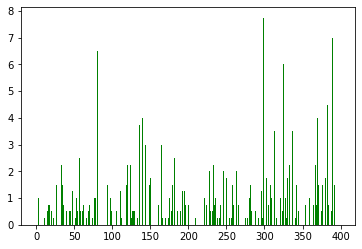

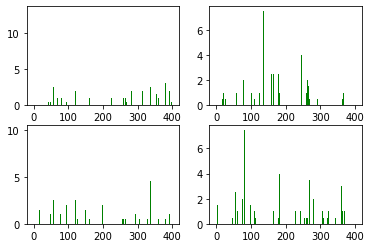

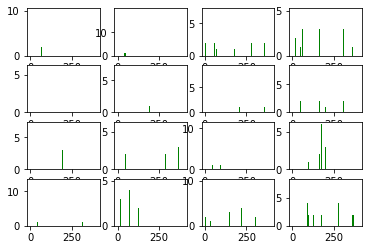

In [0]:
#print(train_histo.shape)
#plt.bar(range(400),h_list[0,:] , color='g')
plt.bar(range(400),train_histo[0,0,:] , color='g')

fig,ax =plt.subplots(2,2)
for i,axi in enumerate(ax.flat):
  axi.bar(range(400),train_histo[0,i+1,:] , color='g')

fig,ax =plt.subplots(4,4)
for i,axi in enumerate(ax.flat):
  axi.bar(range(400),train_histo[0,i+5,:] , color='g')

In [0]:
# form histogram with Spatial Pyramid Matching upto level L with codebook kmeans and k codewords
def getImageFeaturesSPM(L, img):
    W = img.shape[1]
    H = img.shape[0]  
    h = []
    for l in range(L+1):      #레벨별 실행
        w_step = math.floor(W/(2**l))
        h_step = math.floor(H/(2**l))
        x, y = 0, 0
        for i in range(1,2**l + 1):   #가로세로 이중포문
            x = 0
            for j in range(1, 2**l + 1):                
                desc = dense_sift(img[y:y+h_step, x:x+w_step],32)
                #print("type:",desc is None, "x:",x,"y:",y,w_step,h_step, "desc_size:",desc is None)
                code_word=vq(desc,codebook)[0]
                count=np.bincount(code_word,minlength=400)
                weight = 2**(l-L)
                h.append(weight*count)
                x = x + w_step
            y = y + h_step   
    hist = np.array(h).reshape(-1)
    return hist


# get histogram representation for training/testing data
def getHistogramSPM(L, data):    
    x = []
    for i in range(len(data)):        
        hist = getImageFeaturesSPM(L, data[i])        
        x.append(hist)
    return np.array(x)

In [0]:
train_histo = getHistogramSPM(1, train_data)

In [0]:
train_histo.shape

(3060, 21, 400)

In [0]:
#test_histo = getHistogramSPM(1, test_data)

In [0]:
#print(train_histo.shape)
#plt.bar(range(400),h_list[0,:] , color='g')

In [0]:
'''
#test_h=histogram(test_data,codebooksize)
test_h=histogram_vq(test_des)
test_h=np.array(test_h)
test_h
'''

In [0]:
'''
with open('histogram400_256_4.txt','wb') as f:
  pickle.dump(h_list,f)
with open('histogram_test400_256_4.txt','wb') as f:
  pickle.dump(test_h,f)

with open('label.txt','wb') as f:
  pickle.dump(label,f)
with open('test_name.txt','wb') as f:
  pickle.dump(test_name,f)
  '''

In [0]:
'''
with open('histogram400_256_8.txt','rb') as f:
  h_list=pickle.load(f)
with open('histogram_test400_256_8.txt','rb') as f:
  test_h=pickle.load(f)
with open('label.txt','rb') as f:
  label=pickle.load(f)
with open('test_name.txt','rb') as f:
  test_name=pickle.load(f)
'''

In [0]:
X_train,X_val,y_train,y_val=train_test_split(train_histo,label,test_size=0.1,random_state=42)

In [0]:

X_train = xp.asarray(X_train)
X_val = xp.asarray(X_val)
y_train = xp.asarray(y_train)

#svm = SVM(kernel='linear', kernel_params={'sigma': 15}, classification_strategy='ovr', x=X_train, y=y_train, n_folds=3, use_optimal_lambda=True, display_plots=True)
svm = SVM(kernel='linear',classification_strategy='ovr', kernel_params={'C':1},x=X_train, y=y_train)

svm.fit(X_train, y_train)

X_val = xp.asarray(X_val)
val_fit=svm.predict(X_val)
#print(type(xp.asnumpy(val_fit)))

#test_h = xp.asarray(test_h)
#result=svm.prdict(test_h)
#result=xp.asnumpy(result)



ValueError: ignored

In [0]:
test_histo = xp.asarray(test_histo)
result=svm.predict(test_histo)
result=xp.asnumpy(result)


In [0]:
'''
from sklearn.model_selection import GridSearchCV

svm = SVC(kernel='linear')
param_grid = {'C':[1,3]}
grid = GridSearchCV(svm, param_grid, cv=5)

grid.fit(X_train,y_train)
#svm.fit(X_train,y_train)
'''

In [0]:
'''
val_fit=grid.predict(X_val)
#result=grid.predict(test_h)
grid.best_params_
'''

In [0]:
'''
val_fit=svm.predict(X_val)
result=svm.predict(test_histo)
'''

In [0]:
#val_fit=svm.predict(X_val)

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(classification_report(xp.asnumpy(val_fit),y_val))

print(confusion_matrix(xp.asnumpy(val_fit),y_val))

              precision    recall  f1-score   support

           1       1.00      0.75      0.86         4
           2       1.00      0.83      0.91         6
           3       0.75      0.50      0.60         6
           4       1.00      1.00      1.00         2
           5       0.80      0.67      0.73         6
           6       1.00      0.62      0.77         8
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         0
           9       0.14      1.00      0.25         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         4
          12       0.50      0.33      0.40         6
          13       0.00      0.00      0.00         1
          14       0.50      0.50      0.50         2
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         2
          18       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [0]:
result_=np.append(['Category'],result)
result_id=np.append(['Id'],test_name)


In [0]:
#df = pd.DataFrame(result_,columns=['id','Category'])
df = pd.DataFrame(result_,result_id,columns=[' '])
df.to_csv('results_.csv',index=True, header=False)
df

In [0]:
! kaggle competitions submit -c 2019-ml-finalproject -f results_.csv -m "sanhee-1205_l"